In [1]:
#%% IMPORTS
import os
import mne
from os.path import join
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np

OBS: this one has equalized classes

In [2]:

#%% PREPROCESSING

def preprocess_sensor_space_data(subject, date, raw_path,
                                 h_freq=40,
                                 tmin=-0.200, tmax=1.000, baseline=(None, 0),
                                 reject=None, decim=4):
    recording_names = ['001.self_block1',  '002.other_block1',
                       '003.self_block2',  '004.other_block2',
                       '005.self_block3',  '006.other_block3']
    epochs_list = list()
    for recording_index, recording_name in enumerate(recording_names):
        fif_fname = recording_name[4:]
        full_path = join(raw_path, subject, date, 'MEG', recording_name,
                         'files', fif_fname + '.fif')
        print(full_path)
        raw = mne.io.read_raw(full_path, preload=True)
        raw.filter(l_freq=None, h_freq=h_freq, n_jobs=3)
        
        events = mne.find_events(raw, min_duration=0.002)
        if 'self' in recording_name:
            event_id = dict(self_positive=11, self_negative=12,
                            button_press=23)
        elif 'other' in recording_name: 
            event_id = dict(other_positive=21, other_negative=22,
                            button_press=23)
        else:
            raise NameError('Event codes are not coded for file')
        epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline,
                            preload=True, decim=decim)
        epochs.pick_types(meg=True)
        
        epochs_list.append(epochs)
        
        if recording_index == 0:
            X = epochs.get_data()
            y = epochs.events[:, 2]
        else:
            X = np.concatenate((X, epochs.get_data()), axis=0)
            y = np.concatenate((y, epochs.events[:, 2]))
    
    return epochs_list

In [3]:
def preprocess_source_space_data(subject, date, raw_path, subjects_dir,
                                 epochs_list, labels=None,
                                 method='MNE', lambda2=1, pick_ori='normal'):
    if epochs_list is None:
        epochs_list = preprocess_sensor_space_data(subject, date, raw_path,
                                                   return_epochs=True)
    y = np.zeros(0)
    for epochs in epochs_list:
        y = np.concatenate((y, epochs.events[:, 2]))
    
    if labels is not None:
        if isinstance(labels, str):
            labels = [labels]
        
    recording_names = ['001.self_block1', '002.other_block1',
                       '003.self_block2', '004.other_block2',
                       '005.self_block3', '006.other_block3']
    
    X = None

    for label in labels or [None]:
        if label is not None:
            label_path = join(subjects_dir, subject, 'label', label)
            label = mne.read_label(label_path)
        
        for epochs_index, epochs in enumerate(epochs_list):
            fwd_fname = recording_names[epochs_index][4:] + '-oct-6-src-' + \
                        '5120-fwd.fif'
            fwd = mne.read_forward_solution(join(subjects_dir,
                                                 subject, 'bem', fwd_fname))
            noise_cov = mne.compute_covariance(epochs, tmax=0.000)
            inv = mne.minimum_norm.make_inverse_operator(epochs.info,
                                                         fwd, noise_cov)
  
            stcs = mne.minimum_norm.apply_inverse_epochs(epochs, inv, lambda2,
                                                         method, label,
                                                         pick_ori=pick_ori)
            for stc_index, stc in enumerate(stcs):
                this_data = stc.data
                if epochs_index == 0 and stc_index == 0:
                    n_trials = len(stcs)
                    n_vertices, n_samples = this_data.shape
                    this_X = np.zeros(shape=(n_trials, n_vertices, n_samples))
                this_X[stc_index, :, :] = this_data
            
            if epochs_index == 0:
                X = this_X
            else:
                X = np.concatenate((X, this_X))

    return X, y


In [4]:
def get_X_and_y(epochs_list):
    for recording_index in range(len(epochs_list)):
        these_epochs = epochs_list[recording_index]
        if recording_index == 0:
            X = these_epochs.get_data()
            y = these_epochs.events[:, 2]
        else:
            X = np.concatenate((X, these_epochs.get_data()), axis=0)
            y = np.concatenate((y, these_epochs.events[:, 2]))
            
    return X, y

In [5]:
raw_path = '/work/834761/'
subjects_dir = '/work/835482'

epochs_list = preprocess_sensor_space_data('0109', '20230926_000000',
        raw_path=raw_path,
        decim=10) ##CHANGE TO YOUR PATHS # don't go above decim=10

times = epochs_list[0].times # get time points for later


X_sensor,y = get_X_and_y(epochs_list)


RIFG, y = preprocess_source_space_data('0109', '20230926_000000',
        raw_path=raw_path, 
        subjects_dir=subjects_dir,
        labels=['rh.parsopercularis.label','rh.parsorbitalis.label','rh.parstriangularis.label'], epochs_list=epochs_list)
        ##CHANGE TO YOUR PATHS

LIFG, y = preprocess_source_space_data('0109', '20230926_000000',
        raw_path=raw_path, 
        subjects_dir=subjects_dir,
        labels=['lh.parsopercularis.label','lh.parsorbitalis.label','lh.parstriangularis.label'], epochs_list=epochs_list)
        ##CHANGE TO YOUR PATHS


mPFC, y = preprocess_source_space_data('0109', '20230926_000000',
        raw_path=raw_path, 
        subjects_dir=subjects_dir,
        labels=['rh.superiorfrontal.label'], epochs_list=epochs_list)
        ##CHANGE TO YOUR PATHS
                                            

/work/834761/0109/20230926_000000/MEG/001.self_block1/files/self_block1.fif
Opening raw data file /work/834761/0109/20230926_000000/MEG/001.self_block1/files/self_block1.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-03 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-04 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-05 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-06 (1 x 102)  idle
    Range : 452000 ... 875999 =    452.000 ...   875.999 secs
Ready.
Reading 0 ... 423999  =      0.000 ...   423.999 secs...


/tmp/ipykernel_61/1400811285.py:16: RuntimeWarning: This filename (/work/834761/0109/20230926_000000/MEG/001.self_block1/files/self_block1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw(full_path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  15 tasks      | elapsed:    1.3s
[Parallel(n_jobs=3)]: Done 306 out of 306 | elapsed:    4.7s finished


160 events found
Event IDs: [ 11  12  23 202]
Not setting metadata
120 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
9 projection items activated
Using data from preloaded Raw for 120 events and 1201 original time points (prior to decimation) ...


/tmp/ipykernel_61/1400811285.py:28: RuntimeWarning: The measurement information indicates a low-pass frequency of 40.0 Hz. The decim=10 parameter will result in a sampling frequency of 100.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline,


0 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
/work/834761/0109/20230926_000000/MEG/002.other_block1/files/other_block1.fif
Opening raw data file /work/834761/0109/20230926_000000/MEG/002.other_block1/files/other_block1.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-03 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-04 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-05 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-06 (1 x 102)  idle
    Range : 43000 ... 427999 =     43.000 ...   427.999 secs
Ready.
Reading 0 ... 384999  =      0.000 ...   384.999 secs...


/tmp/ipykernel_61/1400811285.py:16: RuntimeWarning: This filename (/work/834761/0109/20230926_000000/MEG/002.other_block1/files/other_block1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw(full_path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  69 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 306 out of 306 | elapsed:    3.0s finished


160 events found
Event IDs: [ 21  22  23 103 202]
Not setting metadata
120 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
9 projection items activated
Using data from preloaded Raw for 120 events and 1201 original time points (prior to decimation) ...


/tmp/ipykernel_61/1400811285.py:28: RuntimeWarning: The measurement information indicates a low-pass frequency of 40.0 Hz. The decim=10 parameter will result in a sampling frequency of 100.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline,


0 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
/work/834761/0109/20230926_000000/MEG/003.self_block2/files/self_block2.fif
Opening raw data file /work/834761/0109/20230926_000000/MEG/003.self_block2/files/self_block2.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-03 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-04 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-05 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-06 (1 x 102)  idle
    Range : 41000 ... 422999 =     41.000 ...   422.999 secs
Ready.
Reading 0 ... 381999  =      0.000 ...   381.999 secs...


/tmp/ipykernel_61/1400811285.py:16: RuntimeWarning: This filename (/work/834761/0109/20230926_000000/MEG/003.self_block2/files/self_block2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw(full_path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  69 tasks      | elapsed:    0.8s


162 events found
Event IDs: [ 11  12  23 103 202]


[Parallel(n_jobs=3)]: Done 306 out of 306 | elapsed:    3.1s finished


Not setting metadata
120 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
9 projection items activated
Using data from preloaded Raw for 120 events and 1201 original time points (prior to decimation) ...


/tmp/ipykernel_61/1400811285.py:28: RuntimeWarning: The measurement information indicates a low-pass frequency of 40.0 Hz. The decim=10 parameter will result in a sampling frequency of 100.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline,


0 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
/work/834761/0109/20230926_000000/MEG/004.other_block2/files/other_block2.fif
Opening raw data file /work/834761/0109/20230926_000000/MEG/004.other_block2/files/other_block2.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-03 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-04 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-05 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-06 (1 x 102)  idle
    Range : 28000 ... 412999 =     28.000 ...   412.999 secs
Ready.
Reading 0 ... 384999  =      0.000 ...   384.999 secs...


/tmp/ipykernel_61/1400811285.py:16: RuntimeWarning: This filename (/work/834761/0109/20230926_000000/MEG/004.other_block2/files/other_block2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw(full_path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  69 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 306 out of 306 | elapsed:    3.2s finished


163 events found
Event IDs: [ 21  22  23 103 202]
Not setting metadata
120 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
9 projection items activated
Using data from preloaded Raw for 120 events and 1201 original time points (prior to decimation) ...


/tmp/ipykernel_61/1400811285.py:28: RuntimeWarning: The measurement information indicates a low-pass frequency of 40.0 Hz. The decim=10 parameter will result in a sampling frequency of 100.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline,


0 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
/work/834761/0109/20230926_000000/MEG/005.self_block3/files/self_block3.fif
Opening raw data file /work/834761/0109/20230926_000000/MEG/005.self_block3/files/self_block3.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-03 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-04 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-05 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-06 (1 x 102)  idle
    Range : 24000 ... 400999 =     24.000 ...   400.999 secs
Ready.
Reading 0 ... 376999  =      0.000 ...   376.999 secs...


/tmp/ipykernel_61/1400811285.py:16: RuntimeWarning: This filename (/work/834761/0109/20230926_000000/MEG/005.self_block3/files/self_block3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw(full_path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  69 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 306 out of 306 | elapsed:    3.2s finished


161 events found
Event IDs: [ 11  12  23 103 202]
Not setting metadata
120 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
9 projection items activated
Using data from preloaded Raw for 120 events and 1201 original time points (prior to decimation) ...


/tmp/ipykernel_61/1400811285.py:28: RuntimeWarning: The measurement information indicates a low-pass frequency of 40.0 Hz. The decim=10 parameter will result in a sampling frequency of 100.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline,


0 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
/work/834761/0109/20230926_000000/MEG/006.other_block3/files/other_block3.fif
Opening raw data file /work/834761/0109/20230926_000000/MEG/006.other_block3/files/other_block3.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-03 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-04 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-05 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-06 (1 x 102)  idle
    Range : 19000 ... 396999 =     19.000 ...   396.999 secs
Ready.
Reading 0 ... 377999  =      0.000 ...   377.999 secs...


/tmp/ipykernel_61/1400811285.py:16: RuntimeWarning: This filename (/work/834761/0109/20230926_000000/MEG/006.other_block3/files/other_block3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw(full_path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  69 tasks      | elapsed:    0.8s


162 events found
Event IDs: [ 21  22  23 103 202]
Not setting metadata
120 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
9 projection items activated
Using data from preloaded Raw for 120 events and 1201 original time points (prior to decimation) ...


[Parallel(n_jobs=3)]: Done 306 out of 306 | elapsed:    3.0s finished
/tmp/ipykernel_61/1400811285.py:28: RuntimeWarning: The measurement information indicates a low-pass frequency of 40.0 Hz. The decim=10 parameter will result in a sampling frequency of 100.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline,


0 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Reading forward solution from /work/835482/0109/bem/self_block1-oct-6-src-5120-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (8196 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Computing rank from data with rank=None
    Using tolerance 2.3e-09 (2.2e-16 eps * 306 dim * 3.4e+04  max singular value)
    Estimated rank (mag + grad): 297
    MEG: rank 297 computed from 306 data channels with 9 projectors
    Created an SSP operator (subspace dimension = 9)
    Setting small MEG eig

In [10]:
#%% SIMPLE CLASSIFICATION

def get_indices(y, triggers):
    indices = list()
    for trigger_index, trigger in enumerate(y):
        if trigger in triggers:
            indices.append(trigger_index)
            
    return indices


def equalize_number_of_indices(X, y):
    unique_classes, class_counts = np.unique(y, return_counts=True)
    min_class_count = class_counts.min()

    keep_inds = np.concatenate([np.random.choice(np.where(y == cls)[0], min_class_count, replace=False) for cls in unique_classes])

    X_equal = X[keep_inds, :, :]
    y_equal = y[keep_inds]

    return X_equal, y_equal


def simple_classification(X, y, triggers,penalty='None',C=1.0):
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import cross_val_predict, StratifiedKFold
    from sklearn.naive_bayes import GaussianNB
    
    n_samples = X.shape[2]
    indices = get_indices(y, triggers)
    
    X = X[indices, :, :]
    y = y[indices]

    X, y = equalize_number_of_indices(X, y)
    
    gnb = GaussianNB()
    sc = StandardScaler()
    cv = StratifiedKFold()
    
    mean_scores = np.zeros(n_samples)
    y_pred_all = []
    y_true_all = []
    
    for sample_index in range(n_samples):
        this_X = X[:, :, sample_index]
        sc.fit(this_X)
        this_X_std = sc.transform(this_X)
        
        y_pred = cross_val_predict(gnb, this_X_std, y, cv=cv)
        y_true = y

        scores = np.mean(y_pred == y_true)
        mean_scores[sample_index] = scores

        y_pred_all.append(y_pred)
        y_true_all.append(y_true)

        print(sample_index)
        
    return mean_scores, y_pred_all, y_true_all

In [11]:
def plot_and_save_classification(times, mean_scores, title, filename):

    plt.figure()
    plt.plot(times, mean_scores)
    plt.hlines(0.50, times[0], times[-1], linestyle='dashed', color='k')
    plt.ylabel('Proportion classified correctly')
    plt.xlabel('Time (s)')
    if title is None:
        pass
    else:
        plt.title(title)
    plt.savefig(filename)
    plt.show()
    plt.close()

#%% RUN FUNCTION
sensor_pos_neg_self, y_pred_sensor_pos_neg_self, y_true_pos_neg_self = simple_classification(X_sensor,
                                  y, triggers=[11, 12],
                                  penalty='l2', C=1e-3)

sensor_pos_self_response, y_pred_sensor_pos_self_response, y_true_sensor_pos_self_response = simple_classification(X_sensor,
                                  y, triggers=[11, 23],
                                  penalty='l2', C=1e-3) # equalize counts?!

sensor_neg_self_response, y_pred_sensor_neg_self_response, y_true_sensor_neg_self_response = simple_classification(X_sensor,
                                  y, triggers=[12, 23],
                                  penalty='l2', C=1e-3) # equalize counts?!


In [12]:
from sklearn.metrics import classification_report

plot_and_save_classification(times, sensor_pos_neg_self,
               title='Sensor space: positive vs. negative (self-made words)',
               filename='figures/sensor_pos_neg_selfmade.png')

# Generate and print the classification report
classification_report_str = classification_report(np.concatenate(y_true_pos_neg_self), np.concatenate(y_pred_sensor_pos_neg_self))
print("Overall Classification Report:")
print(classification_report_str)

plot_and_save_classification(times, sensor_pos_self_response,
               title='Sensor space: positive self-made versus botton press',
               filename='figures/sensor_pos_self_button.png')


# Generate and print the classification report
classification_report_str = classification_report(np.concatenate(y_true_sensor_pos_self_response), np.concatenate(y_pred_sensor_pos_self_response))
print("Overall Classification Report:")
print(classification_report_str)

plot_and_save_classification(times, sensor_neg_self_response,
               title='Sensor space: negative self-made versus button press',
               filename='figures/sensor_neg_self_button.png')


# Generate and print the classification report
classification_report_str = classification_report(np.concatenate(y_true_sensor_neg_self_response), np.concatenate(y_pred_sensor_neg_self_response))
print("Overall Classification Report:")
print(classification_report_str)

In [13]:
#%% COLLAPSE EVENTS (if you want to)
def collapse_events(y, new_value, old_values=list()):
    new_y = y.copy()
    for old_value in old_values:
        new_y[new_y == old_value] = new_value
    return new_y

In [14]:
positive_y = collapse_events(y, 1, [11, 21])
negative_y = collapse_events(y, 2, [12, 22])
self_y =     collapse_events(y, 3, [11, 12])
other_y =    collapse_events(y, 4, [21, 22])

pos_and_neg_y = collapse_events(positive_y, 2, [12, 22]) 
self_and_other_y = collapse_events(self_y, 4, [21, 22])

pos_button =  collapse_events(y, 23, [11, 21])
neg_button =  collapse_events(y, 23, [12, 22])

In [15]:
## POSITIVE SELF TALK VS MOTOR (PM), SANITY CHECK

mean_scores_PM, y_pred_PM, y_true_PM = simple_classification(LIFG, 
                                                                   pos_button,
                                                                   triggers=[1, 2],
                                                                   penalty='l2', 
                                                                   C=1e-3)

ValueError: zero-size array to reduction operation minimum which has no identity


mean_scores_sensor_pos_neg, y_pred_sensor_pos_neg, y_true_sensor_pos_neg = simple_classification(X_sensor, 
                                                                                               pos_and_neg_y, triggers=[1, 2], 
                                                                                               penalty='l2', C=1e-3)

mean_scores_sensor_self_other, y_pred_sensor_self_other, y_true_sensor_self_other = simple_classification(X_sensor, 
                                                                                                        self_and_other_y, triggers=[3, 4], 
                                                                                                        penalty='l2', C=1e-3)


mean_scores_source_pos_neg, y_pred_source_pos_neg, y_true_source_pos_neg = simple_classification(X_source, 
                                                                                               pos_and_neg_y, 
                                                                                               triggers=[1, 2], 
                                                                                               penalty='l2', C=1e-3)


mean_scores_lh_BA44_pos_neg, y_pred_lh_BA44_pos_neg, y_true_lh_BA44_pos_neg = simple_classification(X_lh_BA44, 
                                                                                                  pos_and_neg_y, 
                                                                                                  triggers=[1, 2], penalty='l2', C=1e-3)


mean_scores_rh_BA44_pos_neg, y_pred_rh_BA44_pos_neg, y_true_rh_BA44_pos_neg = simple_classification(X_rh_BA44, 
                                                                                                  pos_and_neg_y, 
                                                                                                  triggers=[1, 2], penalty='l2', C=1e-3)


mean_scores_lh_BA44_pos_neg, y_pred_lh_BA44_pos_neg, y_true_lh_BA44_pos_neg = simple_classification(X_lh_BA44,
                                                                                                    pos_and_neg_y, 
                                                                                                    triggers = [1, 2], 
                                                                                                    penalty='l2', 
                                                                                                    C=1e-3)

mean_scores_rh_BA44_pos_neg, y_pred_rh_BA44_pos_neg, y_true_rh_BA44_pos_neg = simple_classification(X_rh_BA44, 
                                                                                                    pos_and_neg_y, 
                                                                                                    triggers=[1, 2],
                                                                                                    penalty='l2', C=1e-3)

mean_scores_rh_BA45_pos_neg, y_pred_rh_BA45_pos_neg, y_true_rh_BA45_pos_neg = simple_classification(X_rh_BA45, 
                                                                                                    pos_and_neg_y, 
                                                                                                    triggers=[1, 2], 
                                                                                                    penalty='l2', 
                                                                                                    C=1e-3)

mean_scores_lh_BA45_pos_neg, y_pred_lh_BA45_pos_neg, y_true_lh_BA45_pos_neg = simple_classification(X_lh_BA45, 
                                                                                                    pos_and_neg_y, 
                                                                                                    triggers=[1, 2], 
                                                                                                    penalty='l2',
                                                                                                    C=1e-3)

In [ ]:


mean_scores_RIFG, y_pred_RIFG, y_true_RIFG = simple_classification(RIFG, 
                                                                   pos_and_neg_y,
                                                                   triggers=[1, 2], 
                                                                   penalty='l2', 
                                                                   C=1e-3)

mean_scores_LIFG, y_pred_LIFG, y_true_LIFG = simple_classification(LIFG, 
                                                                   pos_and_neg_y,
                                                                   triggers=[1, 2],
                                                                   penalty='l2', 
                                                                   C=1e-3)

mean_scores_mPFC, y_pred_mPFC, y_true_mPFC = simple_classification(mPFC, 
                                                                   pos_and_neg_y, 
                                                                   triggers=[1, 2],
                                                                   penalty='l2',
                                                                   C=1e-3)

import pickle 

f = open('WHOLEBROCAS/sensor_pos_neg.pkl', 'wb')
pickle.dump([mean_scores_sensor_pos_neg, y_pred_sensor_pos_neg, y_true_sensor_pos_neg], f)
f.close()

f = open('WHOLEBROCAS/sensor_self_other.plk', 'wb')
pickle.dump([mean_scores_sensor_self_other, y_pred_sensor_self_other, y_true_sensor_self_other], f)
f.close()

f = open('WHOLEBROCAS/source_pos_neg.plk', 'wb')
pickle.dump([mean_scores_source_pos_neg, y_pred_source_pos_neg, y_true_source_pos_neg], f)
f.close()

f = open('WHOLEBROCAS/lh_BA44_pos_neg.plk', 'wb')
pickle.dump([mean_scores_lh_BA44_pos_neg, y_pred_lh_BA44_pos_neg, y_true_lh_BA44_pos_neg], f)
f.close()

f = open('WHOLEBROCAS/rh_BA44_pos_neg.plk', 'wb')
pickle.dump([mean_scores_rh_BA44_pos_neg, y_pred_rh_BA44_pos_neg, y_true_rh_BA44_pos_neg], f)
f.close()

f = open('WHOLEBROCAS/lh_BA44_pos_neg.plk', 'wb')
pickle.dump([mean_scores_lh_BA44_pos_neg, y_pred_lh_BA44_pos_neg, y_true_lh_BA44_pos_neg], f)
f.close()

f = open('WHOLEBROCAS/rh_BA44_pos_neg.plk', 'wb')
pickle.dump([mean_scores_rh_BA44_pos_neg, y_pred_rh_BA44_pos_neg, y_true_rh_BA44_pos_neg], f)
f.close()

f = open('WHOLEBROCAS/rh_BA45_pos_neg.plk', 'wb')
pickle.dump([mean_scores_rh_BA45_pos_neg, y_pred_rh_BA45_pos_neg, y_true_rh_BA45_pos_neg], f)
f.close()

f = open('WHOLEBROCAS/lh_BA45_pos_neg.plk', 'wb')
pickle.dump([mean_scores_lh_BA45_pos_neg, y_pred_lh_BA45_pos_neg, y_true_lh_BA45_pos_neg], f)
f.close()

f = open('WHOLEBROCAS/RIFG.plk', 'wb')
pickle.dump([mean_scores_RIFG, y_pred_RIFG, y_true_RIFG], f)
f.close()

f = open('WHOLEBROCAS/LIFG.plk', 'wb')
pickle.dump([mean_scores_LIFG, y_pred_LIFG, y_true_LIFG], f)
f.close()

f = open('WHOLEBROCAS/mPFC.plk', 'wb')
pickle.dump([mean_scores_mPFC, y_pred_mPFC, y_true_mPFC], f)
f.close()


In [50]:
import pickle

# Define a list of file names and associated data to save
data_to_save = {
    #'WHOLEBROCAS/sensor_pos_neg.pkl': [mean_scores_sensor_pos_neg, y_pred_sensor_pos_neg, y_true_sensor_pos_neg],
    #'WHOLEBROCAS/sensor_self_other.plk': [mean_scores_sensor_self_other, y_pred_sensor_self_other, y_true_sensor_self_other],
    #'WHOLEBROCAS/source_pos_neg.plk': [mean_scores_source_pos_neg, y_pred_source_pos_neg, y_true_source_pos_neg],
    #'WHOLEBROCAS/lh_BA44_pos_neg.plk': [mean_scores_lh_BA44_pos_neg, y_pred_lh_BA44_pos_neg, y_true_lh_BA44_pos_neg],
    #'WHOLEBROCAS/rh_BA44_pos_neg.plk': [mean_scores_rh_BA44_pos_neg, y_pred_rh_BA44_pos_neg, y_true_rh_BA44_pos_neg],
    #'WHOLEBROCAS/lh_BA44_pos_neg.plk': [mean_scores_lh_BA44_pos_neg, y_pred_lh_BA44_pos_neg, y_true_lh_BA44_pos_neg],
    #'WHOLEBROCAS/rh_BA44_pos_neg.plk': [mean_scores_rh_BA44_pos_neg, y_pred_rh_BA44_pos_neg, y_true_rh_BA44_pos_neg],
    #'WHOLEBROCAS/rh_BA45_pos_neg.plk': [mean_scores_rh_BA45_pos_neg, y_pred_rh_BA45_pos_neg, y_true_rh_BA45_pos_neg],
    #'WHOLEBROCAS/lh_BA45_pos_neg.plk': [mean_scores_lh_BA45_pos_neg, y_pred_lh_BA45_pos_neg, y_true_lh_BA45_pos_neg],
    'WHOLEBROCAS/RIFG.plk': [mean_scores_RIFG, y_pred_RIFG, y_true_RIFG],
    'WHOLEBROCAS/LIFG.plk': [mean_scores_LIFG, y_pred_LIFG, y_true_LIFG],
    'WHOLEBROCAS/mPFC.plk': [mean_scores_mPFC, y_pred_mPFC, y_true_mPFC]
}

# Loop through the dictionary and save the data to corresponding files
for filename, data in data_to_save.items():
    with open(filename, 'wb') as f:
        pickle.dump(data, f)


In [9]:
import os
os.getcwd()

'/work/807746/emma_folder/notebooks/12b_MEG_analysis/python/00_CLEAN'

In [43]:
## read in plk objects

import pickle

# Define a list of file names
file_names = [
    #'WHOLEBROCAS/sensor_pos_neg.plk',
    #'WHOLEBROCAS/sensor_self_other.plk',
    #'WHOLEBROCAS/source_pos_neg.plk',
    #'WHOLEBROCAS/lh_BA44_pos_neg.plk',
    #'WHOLEBROCAS/rh_BA44_pos_neg.plk',
    #'WHOLEBROCAS/lh_BA44_pos_neg.plk',
    #'WHOLEBROCAS/rh_BA44_pos_neg.plk',
    #'WHOLEBROCAS/rh_BA45_pos_neg.plk',
    #'WHOLEBROCAS/lh_BA45_pos_neg.plk',
    'WHOLEBROCAS/RIFG.plk',
    'WHOLEBROCAS/LIFG.plk',
    'WHOLEBROCAS/mPFC.plk'
]

# Create empty dictionaries to store the loaded data
data_dict = {}

# Iterate through the file names and load the data into the dictionary
for file_name in file_names:
    with open(file_name, 'rb') as f:
        data = pickle.load(f)
        data_dict[file_name] = data

# Now you can access the data using the file names as keys in the data_dict dictionary
# For example, to access the data for 'WHOLEBROCAS/sensor_pos_neg.pkl':
#mean_scores_sensor_pos_neg, y_pred_sensor_pos_neg, y_true_sensor_pos_neg = data_dict['WHOLEBROCAS/sensor_pos_neg.pkl']



# ------------ Sensor space: positive vs. negative (self-other collapsed) ------------- #
plot_and_save_classification(times, mean_scores_sensor_pos_neg,title='Sensor space: positive vs. negative (self-other collapsed)',filename='figures/sensor_pos_neg.png')


# Generate and print the classification report
classification_report_str = classification_report(np.concatenate(y_true_sensor_pos_neg), np.concatenate(y_pred_sensor_pos_neg))
print("Overall Classification Report:")
print(classification_report_str)


                                                                                            
# ------------ Sensor space: self vs. other (positive-negative collapsed) ------------ # 
plot_and_save_classification(times, mean_scores_sensor_self_other,
               title='Sensor space: self vs. other (positive-negative collapsed)',
               filename='figures/sensor_self_other.png')


classification_report_str = classification_report(np.concatenate(y_true_sensor_self_other), np.concatenate(y_pred_sensor_self_other))
print("Overall Classification Report:")
print(classification_report_str)


# ------------- Source space: positive vs. negative (self-other collapsed) ---------- # 

plot_and_save_classification(times, mean_scores_source_pos_neg,
               title='Source space: positive vs. negative (self-other collapsed)',
               filename='figures/source_pos_neg.png')


classification_report_str = classification_report(np.concatenate(y_true_source_pos_neg), np.concatenate(y_pred_source_pos_neg))
print("Overall Classification Report:")
print(classification_report_str)



 # ------------ Left BA44: positive vs. negative self talk (self-other collapsed) ----#


plot_and_save_classification(times, mean_scores_lh_BA44_pos_neg,
               title='Left BA44: positive vs. negative self talk (self-other collapsed)',
               filename='figures/lh_BA44_pos_neg.png')


classification_report_str = classification_report(np.concatenate(y_true_lh_BA44_pos_neg), np.concatenate(y_pred_lh_BA44_pos_neg))
print("Overall Classification Report:")
print(classification_report_str)



# ------------ Right BA44: positive vs. negative self talk (self-other collapsed) ----#
plot_and_save_classification(times, mean_scores_rh_BA44_pos_neg,
               title='Right BA44: positive vs. negative self talk (self-other collapsed)',
               filename='figures/rh_BA44_pos_neg.png')


classification_report_str = classification_report(np.concatenate(y_true_rh_BA44_pos_neg), np.concatenate(y_pred_rh_BA44_pos_neg))
print("Overall Classification Report:")
print(classification_report_str)


# ------------ Left BA44: positive vs. negative self talk (self-other collapsed) ----#

plot_and_save_classification(times, mean_scores_lh_BA44_pos_neg,
               title='Left BA44: positive vs. negative self talk (self-other collapsed)',
               filename='figures/lh_BA44_pos_neg.png')


classification_report_str = classification_report(np.concatenate(y_true_lh_BA44_pos_neg), np.concatenate(y_pred_lh_BA44_pos_neg))
print("Overall Classification Report:")
print(classification_report_str)

# ------------ Right BA44: positive vs. negative self talk (self-other collapsed) ----#

plot_and_save_classification(times, mean_scores_rh_BA44_pos_neg,
               title='Right BA44: positive vs. negative self talk (self-other collapsed)',
               filename='figures/rh_BA44_pos_neg.png')


classification_report_str = classification_report(np.concatenate(y_true_rh_BA44_pos_neg), np.concatenate(y_pred_rh_BA44_pos_neg))
print("Overall Classification Report:")
print(classification_report_str)



# ------------ Left BA45: positive vs. negative self talk (self-other collapsed) ----#

plot_and_save_classification(times, mean_scores_lh_BA45_pos_neg,
               title='Left BA45: positive vs. negative self talk (self-other collapsed)',
               filename='figures/lh_BA45_pos_neg.png')


classification_report_str = classification_report(np.concatenate(y_true_lh_BA45_pos_neg), np.concatenate(y_pred_lh_BA45_pos_neg))
print("Overall Classification Report:")
print(classification_report_str)

# ------------ Right BA45: positive vs. negative self talk (self-other collapsed) ----#

plot_and_save_classification(times, mean_scores_rh_BA44_pos_neg,
               title='Right BA45: positive vs. negative self talk (self-other collapsed)',
               filename='figures/rh_BA45_pos_neg.png')


classification_report_str = classification_report(np.concatenate(y_true_rh_BA45_pos_neg), np.concatenate(y_pred_rh_BA45_pos_neg))
print("Overall Classification Report:")
print(classification_report_str)


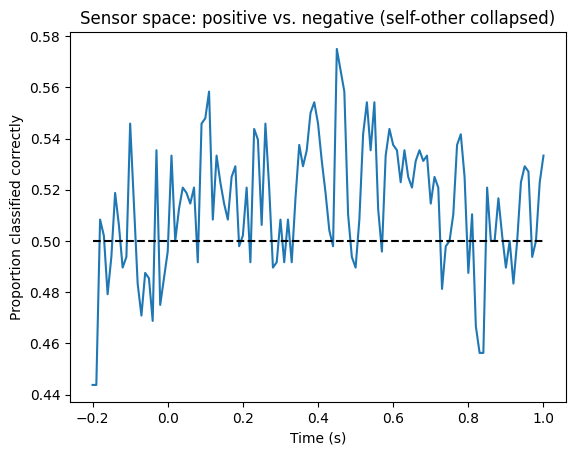

Overall Classification Report:
              precision    recall  f1-score   support

         1.0       0.52      0.42      0.47     29040
         2.0       0.51      0.60      0.55     29040

    accuracy                           0.51     58080
   macro avg       0.51      0.51      0.51     58080
weighted avg       0.51      0.51      0.51     58080



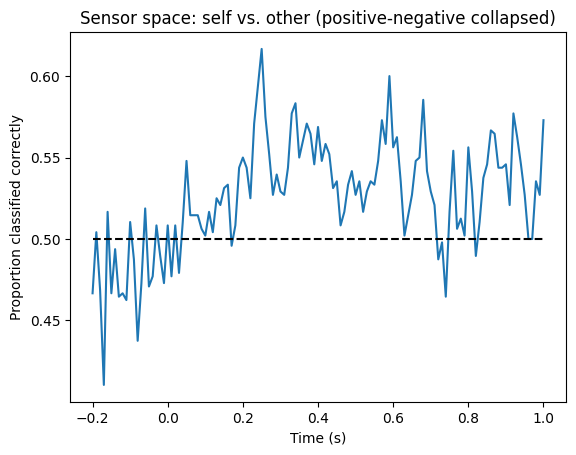

Overall Classification Report:
              precision    recall  f1-score   support

         3.0       0.52      0.61      0.56     29040
         4.0       0.53      0.44      0.48     29040

    accuracy                           0.53     58080
   macro avg       0.53      0.53      0.52     58080
weighted avg       0.53      0.53      0.52     58080



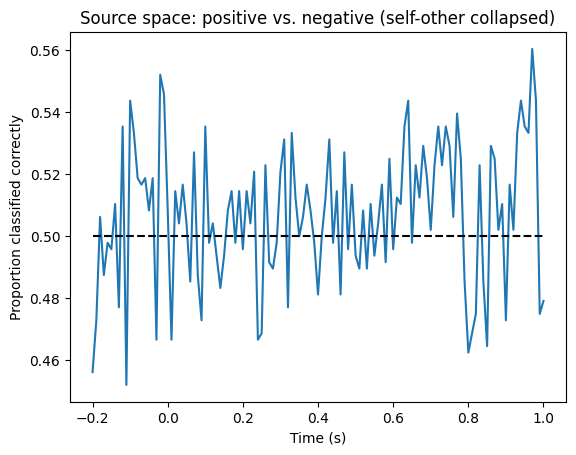

Overall Classification Report:
              precision    recall  f1-score   support

         1.0       0.51      0.33      0.40     29040
         2.0       0.51      0.68      0.58     29040

    accuracy                           0.51     58080
   macro avg       0.51      0.51      0.49     58080
weighted avg       0.51      0.51      0.49     58080



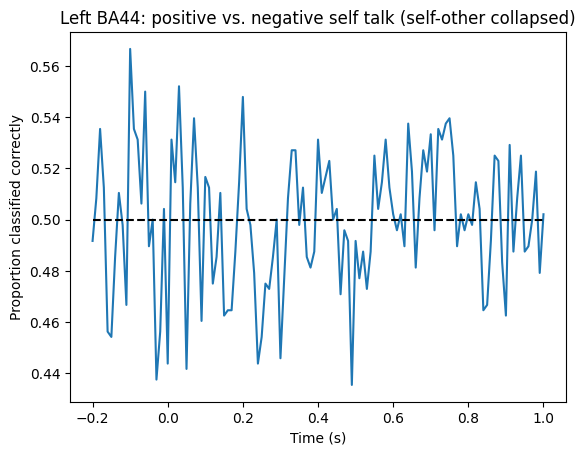

Overall Classification Report:
              precision    recall  f1-score   support

         1.0       0.50      0.37      0.43     29040
         2.0       0.50      0.63      0.56     29040

    accuracy                           0.50     58080
   macro avg       0.50      0.50      0.49     58080
weighted avg       0.50      0.50      0.49     58080



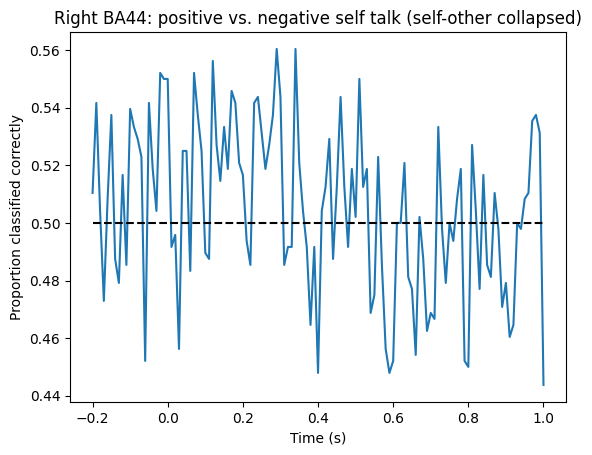

Overall Classification Report:
              precision    recall  f1-score   support

         1.0       0.51      0.50      0.50     29040
         2.0       0.51      0.51      0.51     29040

    accuracy                           0.51     58080
   macro avg       0.51      0.51      0.51     58080
weighted avg       0.51      0.51      0.51     58080



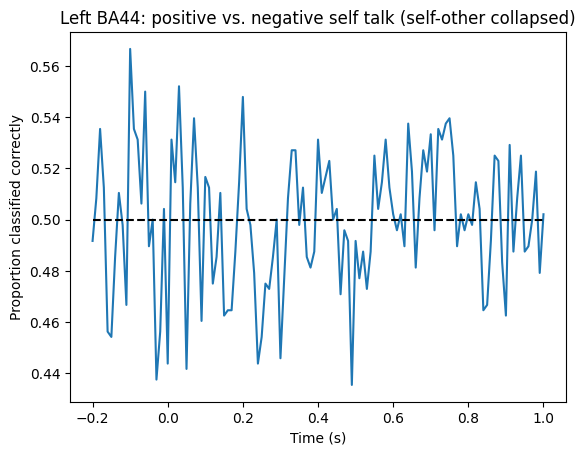

Overall Classification Report:
              precision    recall  f1-score   support

         1.0       0.50      0.37      0.43     29040
         2.0       0.50      0.63      0.56     29040

    accuracy                           0.50     58080
   macro avg       0.50      0.50      0.49     58080
weighted avg       0.50      0.50      0.49     58080



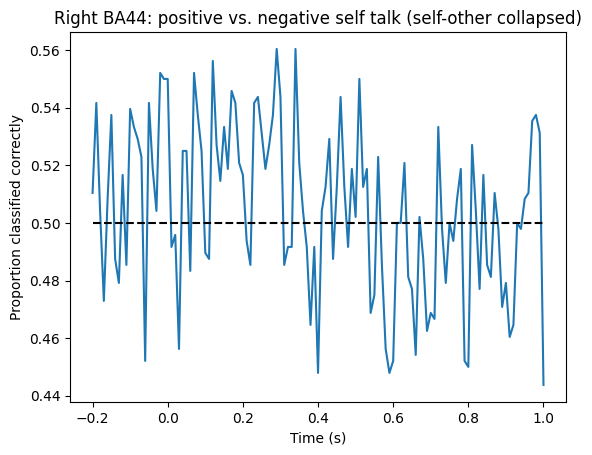

Overall Classification Report:
              precision    recall  f1-score   support

         1.0       0.51      0.50      0.50     29040
         2.0       0.51      0.51      0.51     29040

    accuracy                           0.51     58080
   macro avg       0.51      0.51      0.51     58080
weighted avg       0.51      0.51      0.51     58080



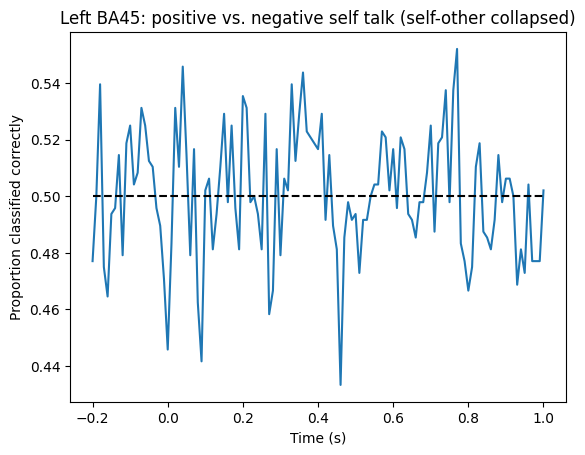

Overall Classification Report:
              precision    recall  f1-score   support

         1.0       0.50      0.38      0.43     29040
         2.0       0.50      0.62      0.55     29040

    accuracy                           0.50     58080
   macro avg       0.50      0.50      0.49     58080
weighted avg       0.50      0.50      0.49     58080



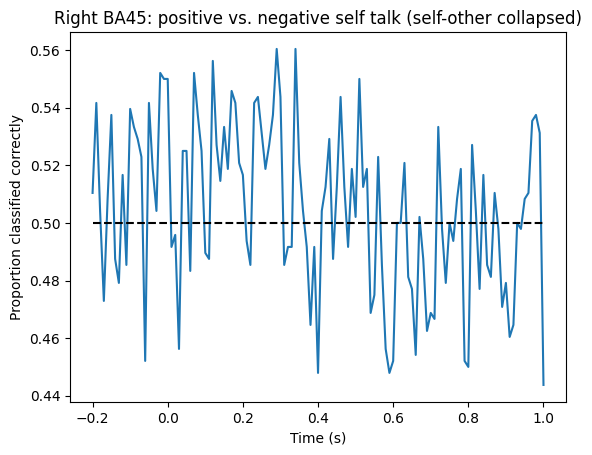

Overall Classification Report:
              precision    recall  f1-score   support

         1.0       0.51      0.45      0.48     29040
         2.0       0.51      0.57      0.54     29040

    accuracy                           0.51     58080
   macro avg       0.51      0.51      0.51     58080
weighted avg       0.51      0.51      0.51     58080



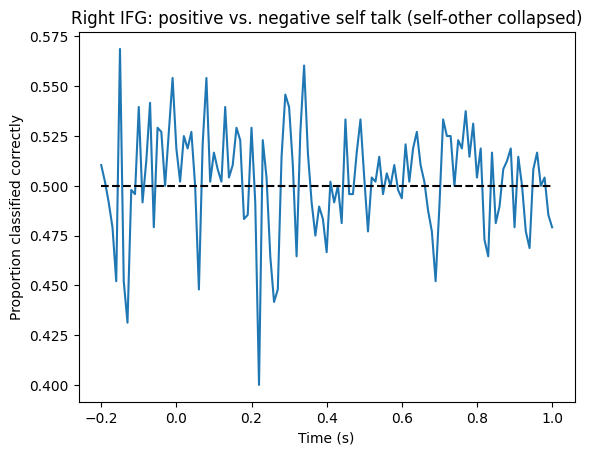

Overall Classification Report:
              precision    recall  f1-score   support

         1.0       0.50      0.45      0.47     29040
         2.0       0.50      0.56      0.53     29040

    accuracy                           0.50     58080
   macro avg       0.50      0.50      0.50     58080
weighted avg       0.50      0.50      0.50     58080



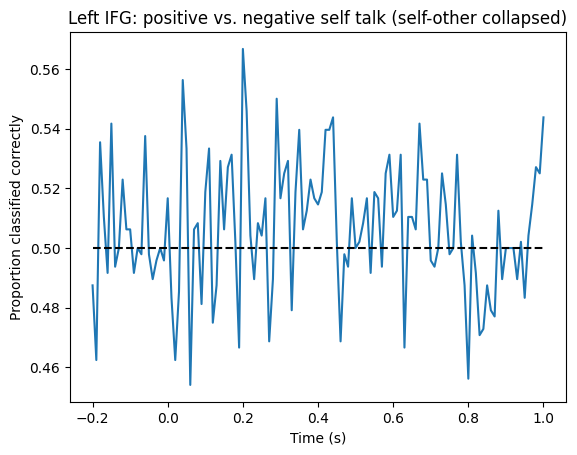

Overall Classification Report:
              precision    recall  f1-score   support

         1.0       0.51      0.38      0.43     29040
         2.0       0.51      0.64      0.56     29040

    accuracy                           0.51     58080
   macro avg       0.51      0.51      0.50     58080
weighted avg       0.51      0.51      0.50     58080



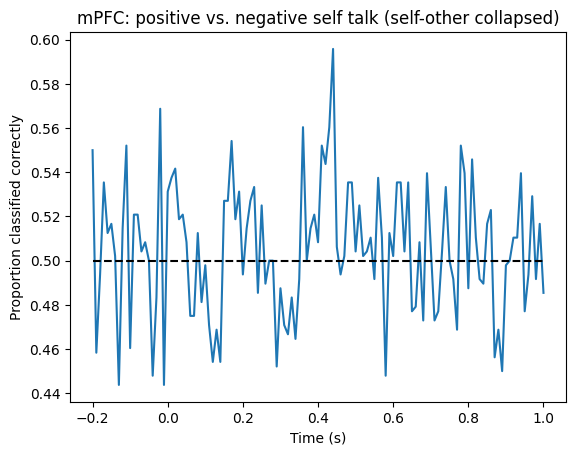

Overall Classification Report:
              precision    recall  f1-score   support

         1.0       0.51      0.49      0.50     29040
         2.0       0.51      0.52      0.51     29040

    accuracy                           0.51     58080
   macro avg       0.51      0.51      0.51     58080
weighted avg       0.51      0.51      0.51     58080



In [45]:


# -------- Right IFG: positive vs. negative self talk (self-other collapsed) ----#

plot_and_save_classification(times, mean_scores_RIFG, 
                             title='Right IFG: positive vs. negative self talk (self-other collapsed)',
                             filename='figures/RIFG_pos_neg.png')


classification_report_str = classification_report(np.concatenate(y_true_RIFG), np.concatenate(y_pred_RIFG))
print("Overall Classification Report:")
print(classification_report_str)

# -------- Left IFG: positive vs. negative self talk (self-other collapsed) ----#

plot_and_save_classification(times, mean_scores_LIFG, 
                             title='Left IFG: positive vs. negative self talk (self-other collapsed)',
                             filename='figures/LIFG_pos_neg.png')


classification_report_str = classification_report(np.concatenate(y_true_LIFG), np.concatenate(y_pred_LIFG))
print("Overall Classification Report:")
print(classification_report_str)

# -------- mPFC: positive vs. negative self talk (self-other collapsed) ----#

plot_and_save_classification(times, mean_scores_mPFC, 
                             title='mPFC: positive vs. negative self talk (self-other collapsed)',
                             filename='figures/mPFC_pos_neg.png')

classification_report_str = classification_report(np.concatenate(y_true_mPFC), np.concatenate(y_pred_mPFC))
print("Overall Classification Report:")
print(classification_report_str)